In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.io.ascii
from scipy.optimize import leastsq
from astropy import units as u
from astropy import constants as const
from astropy.time import Time
from data import bran_disc, bran_z
import pandas as pd
from astropy.coordinates import Distance

# personal import
from sjoert import sync

# local import
import equipartition_functions 
from importlib import reload
reload(equipartition_functions)
from equipartition_functions import *

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
done building interpolator. testing:
{B, nu, p}= 0.05 1.5 2.1
diff alpha (dex): -0.014
diff Ptot (dex): -0.014
diff Snu (dex): -0.014
{B, nu, p}= 0.05 1.5 3.5
diff alpha (dex): -0.002
diff Ptot (dex): -0.002
diff Snu (dex): -0.002
{B, nu, p}= 0.05 17.0 2.1
diff alpha (dex): -0.016
diff Ptot (dex): -0.017
diff Snu (dex): -0.017
{B, nu, p}= 0.05 17.0 3.5
diff alpha (dex): -0.003
diff Ptot (dex): -0.003
diff Snu (dex): -0.003
{B, nu, p}= 2 1.5 2.1
diff alpha (dex): -0.012
diff Ptot (dex): -0.012
diff Snu (dex): 0.000
{B, nu, p}= 2 1.5 3.5
diff alpha (dex): -0.001
diff Ptot (dex): -0.001
diff Snu (dex): -0.000
{B, nu, p}= 2 17.0 2.1
diff alpha (dex): -0.013
diff Ptot (dex): -0.013
diff Snu (dex): 0.000
{B, nu, p}= 2 17.0 3.5
diff alpha (dex): -0.002
diff Ptot (dex): -0.002
diff Snu (dex): -0.001
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
done building interpolator. testing:
{B, nu, p}= 0.05 1.5 2.1
diff alpha (dex): -0.014
diff Pto

In [2]:
def e_eq(b_g, r_cm):
    
    r = r_cm * u.cm
    b = b_g * u.gauss
    e = b**2. * (4./3. * np.pi * r**3)/ (2 * const.mu0) 
    return e.to("erg")

def dedb(b_g, r_cm):
    r = r_cm * u.cm
    b = b_g * u.gauss
    de = 2. * b * (4./3. * np.pi * r**3)/ (2 * const.mu0)
    return de

def dedr(b_g, r_cm):
    r = r_cm * u.cm
    b = b_g * u.gauss
    de = b**2. * (4. * np.pi * r**2.)/ (2 * const.mu0) 
    return de
    

In [3]:
data_rec = astropy.io.ascii.read('./data/at2019dsg_merged.dat', format='fixed_width')

data_rec['eflux_mJy'] = np.clip(data_rec['eflux_mJy'], 0.1*data_rec['flux_mJy'], 1e99) # force errors?

mjd_plot = np.array([58625, 58653, 58703, 58761]) #58818

ts = []
for x in mjd_plot:
    date = Time(x, format="mjd")
    date.format = "iso"
    date.out_subfmt = 'date'
    ts.append(date.value)
print(ts)

B_single = np.zeros((len(mjd_plot),2))
B_sum = np.zeros((len(mjd_plot),2))
R_single = np.zeros((len(mjd_plot),2))
R_sum = np.zeros((len(mjd_plot),2))
E_single = np.zeros((len(mjd_plot),2))

p0 = [np.log10(0.9*1e16/R0), 60, 0.6, -1.00, 5/3., 2.0]

['2019-05-22', '2019-06-19', '2019-08-08', '2019-10-05']


Equipartition Energy: (0.39 +/- 0.065 erg) x 10^48 erg
single-zone:
B=0.996 +/- 0.055 G
d=(1.33 +/- 0.05)x10^16 cm
K = 38526.594920668
Ne = 21403.66249433567
vol = 9.945727665044889e+49 cm3
n = 21403.663844815557
Mean gamma per e 2.2500000000000004
Mean E per e: 1.8420987997853748e-06 erg
Energy Density = 0.003946003063244472 erg / cm3
e density = 2142.123464661193 1 / cm3
N_electrons = 2.130497660442263e+53
chi2: 0.7726441317227516
cooling time at 16 GHz (day) 78.17619525892485


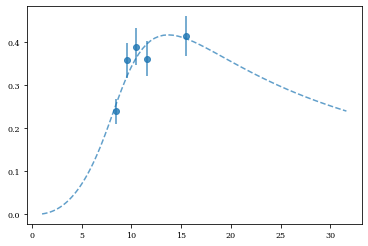

Equipartition Energy: (0.97 +/- 0.09 erg) x 10^48 erg
single-zone:
B=0.733 +/- 0.021 G
d=(2.22 +/- 0.05)x10^16 cm
K = 20847.604459623704
Ne = 11582.001746793772
vol = 4.557916568807363e+50 cm3
n = 11582.002477568725
Mean gamma per e 2.2500000000000004
Mean E per e: 1.8420987997853748e-06 erg
Energy Density = 0.0021352707455299263 erg / cm3
e density = 1159.1510432441025 1 / cm3
N_electrons = 5.283313745752635e+53
chi2: 2.118805126524582
cooling time at 16 GHz (day) 123.90900827722574


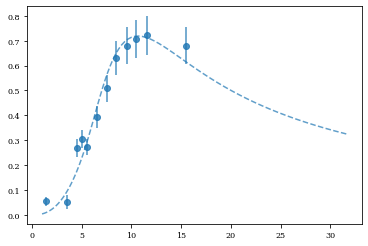

Equipartition Energy: (2.3 +/- 0.22 erg) x 10^48 erg
single-zone:
B=0.547 +/- 0.015 G
d=(3.59 +/- 0.09)x10^16 cm
K = 11636.354377641794
Ne = 6464.640913020817
vol = 1.9435432022092818e+51 cm3
n = 6464.641320912108
Mean gamma per e 2.2500000000000004
Mean E per e: 1.8420987997853748e-06 erg
Energy Density = 0.001191828400971403 erg / cm3
e density = 646.9948306302922 1 / cm3
N_electrons = 1.25746240493605e+54
chi2: 2.1230373243237053
cooling time at 16 GHz (day) 191.88114255629094


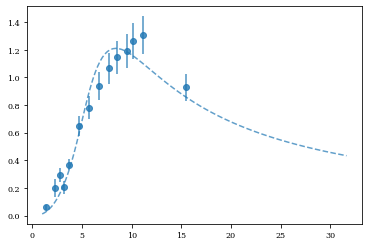

Equipartition Energy: (4.2 +/- 0.38 erg) x 10^48 erg
single-zone:
B=0.329 +/- 0.008 G
d=(6.12 +/- 0.16)x10^16 cm
K = 4213.673839210379
Ne = 2340.929762969741
vol = 9.617323618901926e+51 cm3
n = 2340.929910672433
Mean gamma per e 2.2500000000000004
Mean E per e: 1.8420987997853748e-06 erg
Energy Density = 0.0004315764191274902 erg / cm3
e density = 234.28516384559487 1 / cm3
N_electrons = 2.253196239810547e+54
chi2: 0.4830771748848453
cooling time at 16 GHz (day) 411.0544111453583


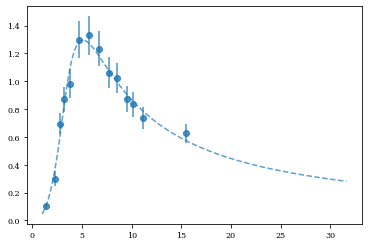

No handles with labels found to put in legend.
No handles with labels found to put in legend.


28 v/c from R_eq     (spherical emitting region): 0.12150904213484458
78 v/c from R_eq     (spherical emitting region): 0.10628263656643716
136 v/c from R_eq     (spherical emitting region): 0.1682878987730585
v/c for neutrino  (spherical emitting region): 4.647640693280171


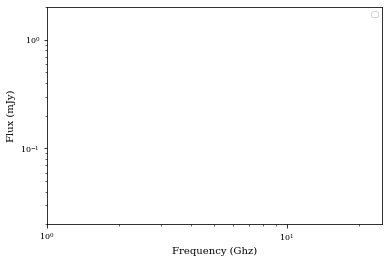

<Figure size 432x288 with 0 Axes>

In [4]:
# #ii = argsort(data_rec['mjd'])
# DeltaT = data_rec['mjd'] - min(data_rec['mjd']) + 50 # test!
# lsq_all = leastsq(res_sumtime, p0, (data_rec['nu_GHz']*1e9, DeltaT, data_rec['flux_mJy'], data_rec['eflux_mJy']), full_output=True)
# print (lsq_all[0])

plt.clf()
for i, mjd in enumerate(mjd_plot): 
    it = abs(data_rec['mjd']-mjd)<10
    ii = it * (data_rec['eflux_mJy']>0)

    if sum(ii)>1:
        nu = data_rec[ii]['nu_GHz']
        Fnu = data_rec[ii]['flux_mJy'] - 0.05
        Fnu_err = data_rec[ii]['eflux_mJy'] 

        p0 = [0.1, 1e16]
        lsq = leastsq(res_single, p0, (nu*1e9, Fnu, Fnu_err), full_output=True)
        #p0 = [lsq[0][0], lsq[0][1]] # guess next initial parameters
        
        e_erg = e_eq(lsq[0][0], lsq[0][1])
        
        # Analytic value for errors
        
        de_b = (dedb(lsq[0][0], lsq[0][1]) * sqrt(lsq[1][0][0]) * u.gauss).to("erg")
        de_r = (dedr(lsq[0][0], lsq[0][1]) * sqrt(lsq[1][1][1]) * u.cm).to("erg")
        
        err = sqrt(de_b ** 2. + de_r ** 2.)        
        print(f"Equipartition Energy: ({e_erg.value/10.**48:.2g} +/- {err/10.**48 :.2g}) x 10^48 erg")

        if lsq[1] is not None:
            print ('''single-zone:\nB={0:0.3f} +/- {1:0.3f} G\nd=({2:0.2f} +/- {3:0.2f})x10^16 cm'''.format(lsq[0][0],  sqrt(lsq[1][0][0]), lsq[0][1]/1e16, sqrt(lsq[1][1][1])/1e16)		)

            B_single[i,:], R_single[i,:] = (lsq[0][0],  sqrt(lsq[1][0][0])), (lsq[0][1], sqrt(lsq[1][1][1]))
        if len(p0)>2: 
            print ('p={0:0.2f} +/- {1:0.2f}'.format(lsq[0][2],sqrt(lsq[1][2,2])))

        B_single[i,:], R_single[i,:] = (lsq[0][0],  sqrt(lsq[1][0][0])), (lsq[0][1], sqrt(lsq[1][1][1]))
        E_single[i][0] = e_erg.value
        E_single[i][1] = err.value
        
        p_electron = 2.8
        
        vol = 4. * np.pi * (lsq[0][1] * u.cm)**3/.3
        K = sync.K(lsq[0][0], p=p_electron, gamma_max=10000.0, gamma_min=1.0, eps_e=1)
        print(f"K = {K}")
        print(f"Ne = {sync.Ne(lsq[0][0], p=p_electron, gamma_max=10000.0, gamma_min=1.0, eps_e=1)}")
        print(f"vol = {vol}")
        n = (K / (p_electron - 1))
        gamma_per_e = K/((p_electron - 2.) * n)
        print(f"n = {n}")
        print(f"Mean gamma per e {gamma_per_e}")
        E_per_e = (gamma_per_e * const.m_e * const.c**2).to("erg")
        print(f"Mean E per e: {E_per_e}")
        print(f"Energy Density = {e_erg / vol}")
        print(f"e density = {e_erg / vol / E_per_e}")
        print(f"N_electrons = {e_erg / E_per_e}")
        
#         print(f"E per e = {const.m_e * const.c**2 * }")

        lbl = sjoert.simtime.mjdtodate(np.mean(data_rec['mjd'][it])).strftime('%y/%m/%d')
        line = plt.errorbar(nu, Fnu,Fnu_err, fmt='o', label=lbl, zorder=10-i, alpha=0.8)
        # ii = it * (data_rec['eflux_mJy']<0)
        # plt.errorbar(data_rec[ii]['nu_GHz'], data_rec[ii]['flux_mJy'], fmt='v', zorder=10-i, alpha=0.8, color=line[0].get_color())

        #plot single-comp model
        xx = np.logspace(9,10.5, 100)
        plt.plot(xx/1e9, fit_single(xx, lsq[0])*1e23*1e3,  '--',alpha=0.7, color=line[0].get_color()) #label=ll1
        ll1=''		

        print ('chi2:', sum(lsq[2]['fvec']**2)/(sum(ii)-len(p0)))
        print ('cooling time at 16 GHz (day)', sync.cooling_extra(lsq[0][0], 16e9)/3600/24)
        #print ('cooling time at 16*(t-300) GHz (day)', sync.cooling_extra(lsq[0][0], 16e9*np.clip(300-t,1,300))/3600/24)
        plt.pause(0.01)


#R0 = 1e15
#p0 = [np.log10(0.9*1e16/R0), 60, 0.6, -1.00, 5/3., 2.0]

plt.legend()

plt.xlim(1.0,25) 
plt.ylim(0.02, 2)
plt.yscale('log')
plt.xscale('log')

for i in [1,2,3]:
    print (mjd_plot[i]-mjd_plot[0], 'v/c from R_eq     (spherical emitting region):', (R_single[i,0]-R_single[i-1,0]) / ((mjd_plot[i]-mjd_plot[i-1])*3600*24) / 3e10) 
print ('v/c for neutrino  (spherical emitting region):', (R_single[3,0]-1e15) / ((5)*3600*24) / 3e10) 

plt.xlabel('Frequency (Ghz)')
plt.ylabel('Flux (mJy)')
plt.legend()
plt.show()
plt.pause(0.01)

plt.savefig('./plots/at2019dsg_radio_singlefit.pdf')

writing:
 ./data/at2019dsg_RB_fit_p3.0.dat


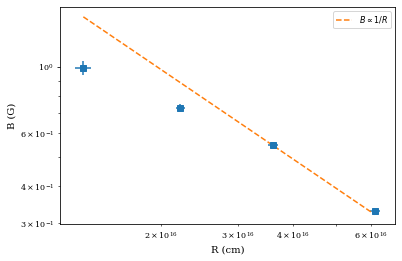

In [5]:
plt.clf()
idx = R_single[:,0]>0

plt.errorbar(R_single[idx,0], B_single[idx,0],xerr=R_single[idx,1],yerr=B_single[idx,1], fmt='s')
plt.plot(R_single[:,0], B_single[2,0]*(R_single[:,0]/R_single[2,0])**(-1),'--',label=r'$B\propto 1/R$')
plt.legend()
#plt.errorbar(mjd_plot[idx]-mjd_plot[1], R_single[idx,0],yerr=R_single[idx,1],  fmt='s')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('R (cm)')
plt.ylabel('B (G)')
plt.savefig('./plots/at2019dsg_RB.pdf')

fname = './data/at2019dsg_RB_fit_p{0:0.1f}.dat'.format(p_electron_single)
sjoert.io.writecols(cols=[mjd_plot, R_single[:,0],R_single[:,1], B_single[:,0], B_single[:,1], E_single[:,0], E_single[:,1]],
    filename=fname,
    names=["MJD", 'R_cm', 'eR_cm', 'B_Gauss', 'eB_Gauss', "E_erg", "eE_erg"], delimiter=',')

astropy.io.ascii.write([mjd_plot, R_single[:,0]/10.**16,R_single[:,1]/10.**16, B_single[:,0], B_single[:,1], E_single[:,0]/10**48, E_single[:,1]/10**48],
    fname, names=["MJD", 'R_cm_16', 'eR_cm_16', 'B_Gauss', 'eB_Gauss', "E_erg_48", "eE_erg_48"],
    formats={"MJD": "0.0f", 'R_cm_16':'0.2f','eR_cm_16':'0.2f','B_Gauss':'0.2f', 'eB_Gauss':'0.2f', 'E_erg_48':'0.2f', 'eE_erg_48':'0.2f'}, 
    overwrite=True)



# ii = argsort(vla0['DeltaT'])
# print vla0[ii]['DeltaT']
# lsq_all = leastsq(res_sumtime, p0, (vla0[ii]['nu']*1e9, vla0[ii]['DeltaT'], vla0[ii]['Fnu']-VLA_sub[ii], vla0[ii]['Fnu_err']), full_output=True)
# print lsq_all[0]

Start date: 26.248983988072723


Text(0.5, 0, 'Time Since Discovery (days)')

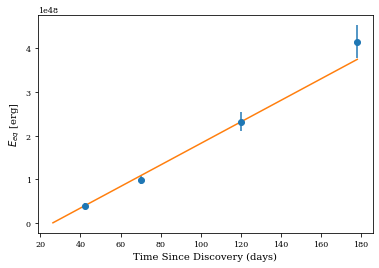

In [6]:
grad = (E_single.T[0][-2] - E_single.T[0][0])/(mjd_plot[-2] - mjd_plot[0])
c = E_single.T[0][-2] - grad * (mjd_plot[-2])

def fit_e(t):
    return grad*t + c

start = -c/grad - bran_disc.mjd

print(f"Start date: {start}")

x_range = np.linspace(start, mjd_plot[-1] - bran_disc.mjd, 100)

plt.figure()
plt.errorbar(np.array(mjd_plot) - bran_disc.mjd, E_single.T[0], yerr=E_single.T[1], fmt=" ", marker="o")
plt.plot(x_range, fit_e(x_range + bran_disc.mjd))
plt.ylabel(r"$E_{eq}$ [erg]")
plt.xlabel("Time Since Discovery (days)")

In [7]:
from pylatex import Document, Section, Subsection, Command, Tabular
from pylatex.utils import italic, NoEscape

def fill_document(doc, df, headings):
    """Add a section, a subsection and some text to the document.

    :param doc: the document
    :type doc: :class:`pylatex.document.Document` instance
    """
    with doc.create(Section('A section')):
        doc.append('Some regular text and some ')
        doc.append(italic('italic text. '))

        with doc.create(Subsection('A subsection')):
            doc.append('Also some crazy characters: $&#{}')
            
            with doc.create(Subsection('Table of something')):
                with doc.create(Tabular('|' + "".join(["c|" for _ in headings]))) as table:
                    table.add_hline()
                    table.add_row(tuple([NoEscape(r"\textbf{" + x + "}") for x in headings]))
                    table.add_hline()
                    for _, row in df.iterrows():
                        entry = tuple([x for x in row])
                        table.add_row(entry)
                    table.add_hline()


In [8]:
df = pd.read_table(fname, sep=" ")
df["MJD"] = ts

# df["R_cm"] /= 10.**16.
# # df["eR_cm"] /= 10.**16.
# df["E_erg"] /= 10.**48.
# df["eE_erg"] /= 10.**48.

col_headings = [
    "Observation Date",
    r"$R_{eq} (10^{16}$ cm)",
    r"$\sigma_{R} (10^{16}$ cm)",
    r"$B_{eq}$ (Gauss)",
    r"$\sigma_{B}$ (Gauss)",
    r"$E_{eq} (10^{48}$ erg)",
    r"$\sigma_{E} (10^{48}$ erg)"
]


# if __name__ == '__main__':
# Basic document
doc = Document('basic')

fill_document(doc, df, col_headings)

# Add stuff to the document
with doc.create(Section('A second section')):
    doc.append('Some text.')

tex = doc.dumps()  # The document as string in LaTeX syntax
print(tex)

\documentclass{article}%
\usepackage[T1]{fontenc}%
\usepackage[utf8]{inputenc}%
\usepackage{lmodern}%
\usepackage{textcomp}%
\usepackage{lastpage}%
%
%
%
\begin{document}%
\normalsize%
\section{A section}%
\label{sec:Asection}%
Some regular text and some %
\textit{italic text. }%
\subsection{A subsection}%
\label{subsec:Asubsection}%
Also some crazy characters: \$\&\#\{\}%
\subsection{Table of something}%
\label{subsec:Tableofsomething}%
\begin{tabular}{|c|c|c|c|c|c|c|}%
\hline%
\textbf{Observation Date}&\textbf{$R_{eq} (10^{16}$ cm)}&\textbf{$\sigma_{R} (10^{16}$ cm)}&\textbf{$B_{eq}$ (Gauss)}&\textbf{$\sigma_{B}$ (Gauss)}&\textbf{$E_{eq} (10^{48}$ erg)}&\textbf{$\sigma_{E} (10^{48}$ erg)}\\%
\hline%
2019{-}05{-}22&1.33&0.05&1.0&0.06&0.39&0.06\\%
2019{-}06{-}19&2.22&0.05&0.73&0.02&0.97&0.09\\%
2019{-}08{-}08&3.59&0.09&0.55&0.01&2.32&0.22\\%
2019{-}10{-}05&6.12&0.16&0.33&0.01&4.15&0.38\\%
\hline%
\end{tabular}

%
\section{A second section}%
\label{sec:Asecondsection}%
Some text.

%
\en

In [9]:
dl = Distance(z=bran_z).to("cm")
frac = 10**17 * u.cm/dl
print(dl)
print(frac*60*60*360)

7.261835039013887e+26 cm
0.00017846728726792846 cm / cm
